In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.callbacks import EarlyStopping
%matplotlib inline

In [79]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [80]:
df = pd.read_csv('/content/drive/MyDrive/Big data/UAS/dataset_komentar_instagram_cyberbullying.csv',delimiter=',',encoding='latin-1')
df.head()

,ï»¿Id,Sentiment,Instagram Comment Text
0,1,negative,<USERNAME> TOLOL!! Gak ada hubungan nya kegug...
1,2,negative,Geblek lo tata...cowo bgt dibela2in balikan......
2,3,negative,Kmrn termewek2 skr lengket lg duhhh kok labil ...
3,4,negative,"Intinya kalau kesel dengan ATT nya, gausah ke ..."
4,5,negative,"hadewwwww permpuan itu lg!!!!sakit jiwa,knp ha..."


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Instagram Comment')

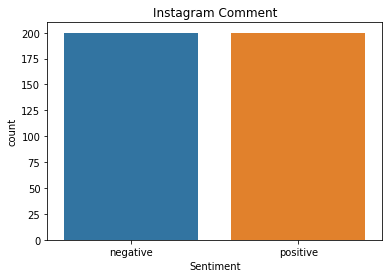

In [81]:
sns.countplot(df.Sentiment)
plt.xlabel('Sentiment')
plt.title('Instagram Comment')

In [82]:
X = df['Instagram Comment Text']
Y = df.Sentiment
le = LabelEncoder()
Y = le.fit_transform(Y)
Y = Y.reshape(-1,1)

In [83]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.15)

In [84]:
max_words = 1000
max_len = 150
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

In [85]:
import gc
gc.collect()

52453

In [86]:
from gensim.models.keyedvectors import KeyedVectors
import gensim

In [87]:
# Identify max length of reviews
max_length = 0
for review_number in range(len(sequences)):
  numberofwords=len(sequences[review_number])
  if (numberofwords) > (max_length):
    max_length = numberofwords
print(max_length)

113


In [88]:
# Takes RAM 
word_vectors = KeyedVectors.load_word2vec_format('/content/drive/MyDrive/Big data/UAS/SKIPGRAM/idwiki_word2vec_200.bin', binary=True)
EMBEDDING_DIM=200

In [89]:
# Tokenizing Text -> Repsesenting each word by a number
# Mapping of orginal word to number is preserved in word_index property of tokenizer

#Tokenized applies basic processing like changing it yo lower case, explicitely setting that as False
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)

X = tokenizer.texts_to_sequences(X)

In [90]:
# lets check the first 10 words of first news
#every word has been represented with a number
X[0][:10]

[4, 211, 11, 15, 499, 5, 1173, 178, 62, 688]

In [91]:
#Lets check few word to numerical replesentation
#Mapping is preserved in dictionary -> word_index property of instance
word_index = tokenizer.word_index
for word, num in word_index.items():
    print(f"{word} -> {num}")
    if num == 10:
        break        

yg -> 1
di -> 2
dan -> 3
username -> 4
nya -> 5
ya -> 6
ga -> 7
dia -> 8
aja -> 9
sama -> 10


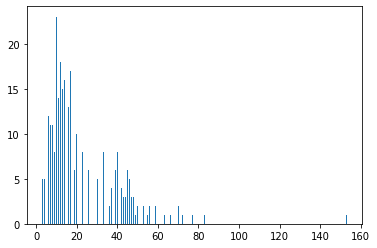

In [92]:
# For determining size of input...

# Making histogram for no of words in news shows that most news article are under 700 words.
# Lets keep each news small and truncate all news to 700 while tokenizing
plt.hist([len(x) for x in X], bins=500)
plt.show()

# Its heavily skewed. There are news with 5000 words? Lets truncate these outliers :) 

In [93]:
nos = np.array([len(x) for x in X])
len(nos[nos  < 700])
# Out of 48k news, 44k have less than 700 words

400

In [94]:
#all news has 700 words (in numerical form now). If they had less words, they have been padded with 0
# 0 is not associated to any word, as mapping of words started from 1
# 0 will also be used later, if unknows word is encountered in test set
len(X[0])

35

In [95]:
# Adding 1 because of reserved 0 index
# Embedding Layer creates one more vector for "UNKNOWN" words, or padded words (0s). This Vector is filled with zeros.
# Thus our vocab size inceeases by 1
vocab_size = len(tokenizer.word_index) + 1

In [96]:
# Function to create weight matrix from word2vec gensim model
def get_weight_matrix(model, vocab):
    # total vocabulary size plus 0 for unknown words
    vocab_size = len(vocab) + 1
    # define weight matrix dimensions with all 0
    weight_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
    # step vocab, store vectors using the Tokenizer's integer mapping
    for word, i in vocab.items():
        weight_matrix[i] = model[word]
    return weight_matrix

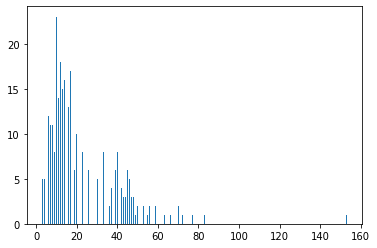

In [97]:
# For determining size of input...

# Making histogram for no of words in news shows that most news article are under 700 words.
# Lets keep each news small and truncate all news to 700 while tokenizing
plt.hist([len(x) for x in X], bins=500)
plt.show()

# Its heavily skewed. There are news with 5000 words? Lets truncate these outliers :) 

In [98]:
nos = np.array([len(x) for x in X])
len(nos[nos  < 700])
# Out of 48k news, 44k have less than 700 words

400

In [99]:
#Lets keep all news to 700, add padding to news with less than 700 words and truncating long ones
from keras.preprocessing.sequence import pad_sequences
maxlen = 700 

#Making all news of size maxlen defined above
X = pad_sequences(X, maxlen=maxlen)

In [100]:
#all news has 700 words (in numerical form now). If they had less words, they have been padded with 0
# 0 is not associated to any word, as mapping of words started from 1
# 0 will also be used later, if unknows word is encountered in test set
len(X[0])

700

In [103]:
# Adding 1 because of reserved 0 index
# Embedding Layer creates one more vector for "UNKNOWN" words, or padded words (0s). This Vector is filled with zeros.
# Thus our vocab size inceeases by 1
vocab_size = len(tokenizer.word_index) + 1

In [105]:
# Function to create weight matrix from word2vec gensim model
def get_weight_matrix(model, vocab):
    # total vocabulary size plus 0 for unknown words
    vocab_size = len(vocab) + 1
    # define weight matrix dimensions with all 0
    weight_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
    # step vocab, store vectors using the Tokenizer's integer mapping
    for word, i in vocab.items():
        weight_matrix[i] = model[word]
    return weight_matrix

# RNN

In [106]:
def RNN():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,50,input_length=max_len)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

In [107]:
model = RNN()
model.summary()
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 150)]             0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 150, 50)           50000     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                29440     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640     
_________________________________________________________________
activation_2 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
out_layer (Dense)            (None, 1)                 257 

In [108]:
model.fit(sequences_matrix,Y_train,batch_size=128,epochs=10,
          validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

Epoch 1/10
3/3 [==============================] - 3s 411ms/step - loss: 0.6923 - accuracy: 0.4654 - val_loss: 0.7036 - val_accuracy: 0.4118


In [109]:
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)

In [110]:
accr = model.evaluate(test_sequences_matrix,Y_test)

2/2 [==============================] - 0s 20ms/step - loss: 0.6969 - accuracy: 0.4333


In [111]:
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

Test set
  Loss: 0.697
  Accuracy: 0.433


# LSTM

In [112]:
def LSTMmodel(X_train, y_train,X_test, y_test):
  #defined model
  model = Sequential()
  model.add(Embedding(input_dim=jumlah_index, output_dim=200, weights=[embedding_matrix], input_length=max_len_word))
  model.add(LSTM(100, return_sequences=False))
  model.add(Dropout(0.5))
  # model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
  # model.add(Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
  model.add(Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.01)))
  model.summary()

  #compile model
  adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

  #fit model
  history = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs=10, batch_size=32, verbose=1, callbacks=mcp)
 
  #evaluate the model
  # scores = model.evaluate(X_test, y_test, verbose=1)
  # summarize history for accuracy
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  return history,model

In [ ]:
model.fit(sequences_matrix,Y_train,batch_size=128,epochs=10,
          validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

Epoch 1/10
3/3 [==============================] - 0s 143ms/step - loss: 0.6879 - accuracy: 0.5221 - val_loss: 0.6834 - val_accuracy: 0.7059


In [ ]:
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)

In [ ]:
accr = model.evaluate(test_sequences_matrix,Y_test)

2/2 [==============================] - 0s 20ms/step - loss: 0.6856 - accuracy: 0.7000


In [ ]:
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

Test set
  Loss: 0.686
  Accuracy: 0.700
